In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete = load_umachine_sdss_with_meert15()
no_data_mask = np.isnan(full_sdss['Magr_tot_meert15'])

mask = ~no_data_mask & behroozi_complete
sdss = full_sdss[mask]

from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()

mask_sf = sdss['ssfr'] >= -10.75
mask_gv = (sdss['ssfr'] < -10.75) & (sdss['ssfr'] >= -11.25)
mask_q = (sdss['ssfr'] < -11.25)

mock['is_main_sequence'] = mock['ssfr'] >= -10.75
mock['is_green_valley'] = (mock['ssfr'] < -10.75) & (mock['ssfr'] >= -11.25)
mock['is_quenched'] = (mock['ssfr'] < -11.25)
mock['logsm'] = np.log10(mock['obs_sm'])

Total runtime = 0.42 seconds


In [24]:
from galsize_models.models.bulge_disk_double_power_law import data_vector_prediction
from galsize_models.measurements.sdss_covariance import logsm_bins, logsm_mids

norm1, norm2, alpha1, alpha2, scatter = 0.0125, 0.08, 1, 0.7, 0.2
params = norm1, norm2, alpha1, alpha2, scatter
model_data_vector = data_vector_prediction(params, mock, logsm_bins)

In [25]:
from galsize_models.measurements.sdss_covariance import sdss_measurements_and_cov
sdss_data_vector, sdss_cov = sdss_measurements_and_cov()

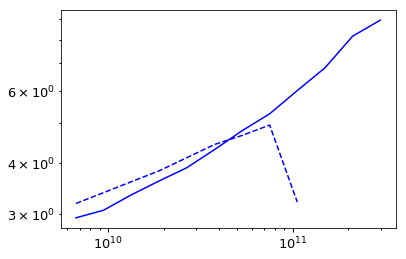

In [26]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

__=ax.loglog()

ifirst, ilast = 0, npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='blue')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='blue')

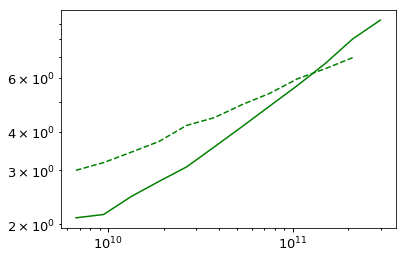

In [27]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

__=ax.loglog()

ifirst, ilast = npts, 2*npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='green')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='green')

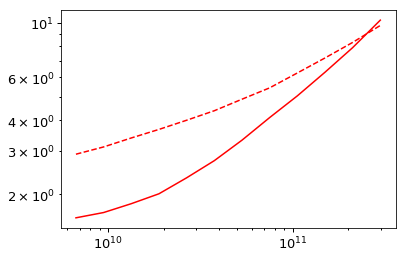

In [28]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

__=ax.loglog()

ifirst, ilast = 2*npts, 3*npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='red')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='red')

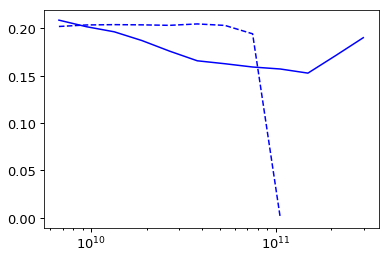

In [21]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = 3*npts, 4*npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='blue')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='blue')

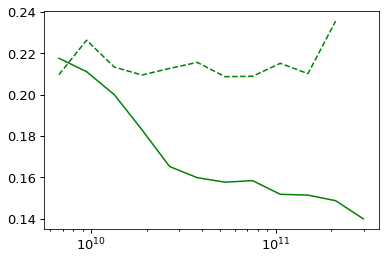

In [22]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = 4*npts, 5*npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='green')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='green')

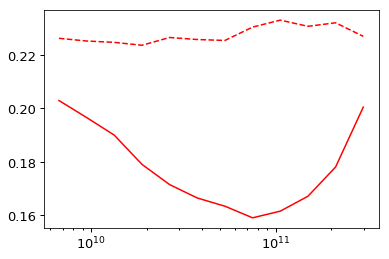

In [23]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = 5*npts, 6*npts
__=ax.plot(10**logsm_mids, sdss_data_vector[ifirst:ilast], color='red')
__=ax.plot(10**logsm_mids, model_data_vector[ifirst:ilast], '--', color='red')